<a href="https://colab.research.google.com/github/manuelsalazarleon/DataScience1/blob/main/Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final – Parte I
**Visualizaciones en Python**

## Abstract
Este cuaderno presenta un análisis exploratorio del dataset **Uber.csv**, centrado en la comprensión de los patrones
temporales y, cuando está disponible, espaciales y operacionales de la demanda de viajes. A partir de la columna temporal
detectada (`Date`), se construyeron variables derivadas como **mes**, **día de la semana** y **hora**, que permiten
caracterizar el comportamiento de los viajes a lo largo del tiempo. El análisis incluye resúmenes numéricos, diagnóstico
de valores perdidos y visualizaciones univariadas, bivariadas y multivariadas. Entre estas últimas se destaca un mapa de
calor **día vs. hora** que sintetiza la intensidad de viajes, una gráfica de barras apiladas **mes vs. base** (si la columna
de base está disponible) y una nube de puntos **latitud vs. longitud** en la que el **tamaño** de los puntos codifica la hora
del día (si se dispone de coordenadas).

Los hallazgos preliminares buscan responder preguntas sobre **picos de demanda** (por ejemplo, horas punta laborales y fines
de semana nocturnos), **estacionalidad mensual** y posibles **diferencias operativas entre bases**. El análisis sugiere que
el uso de transformaciones temporales simples, combinado con conteos y normalizaciones por grupo, permite construir
indicadores interpretables sobre la dinámica de la oferta y la demanda. En términos de calidad de datos, se cuantifican y
localizan los **valores perdidos**, discutiendo su impacto potencial en los resultados. Las visualizaciones se diseñan para
soportar la toma de decisiones analítica del proyecto final del curso, orientando hipótesis que podrán refinarse con modelos
predictivos o segmentaciones posteriores.

En suma, este avance establece una línea base reproducible del dataset, documenta su estructura y brinda evidencia gráfica y
numérica inicial para validar o refutar hipótesis sobre patrones temporales, espaciales y operativos en los viajes de Uber.

## Preguntas e hipótesis de interés
- **H1 (pico laboral):** La intensidad de viajes es mayor en horas punta (7–9 y 17–20) de días laborales (0–4).
- **H2 (ocio/nocturno):** La demanda aumenta en noches de viernes y sábado (días 4–5) respecto del resto de la semana.
- **H3 (estacionalidad):** Existen diferencias por **mes**, coherentes con temporadas altas/bajas.

## Carga y preparación de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
df = pd.read_csv("https://raw.githubusercontent.com/manuelsalazarleon/DataScience1/refs/heads/main/Uber.csv", low_memory=False)
df.columns = [c.strip().replace(" ", "_").replace("-", "_") for c in df.columns]

# Detectar columna temporal
candidatas = ['Date', 'Time']
dt_col = None
for c in candidatas:
    try:
        df[c] = pd.to_datetime(df[c], errors="raise", infer_datetime_format=True)
        dt_col = c
        break
    except Exception:
        continue

if dt_col is None:
    df["Surrogate_DateTime"] = pd.to_datetime("2014-01-01") + pd.to_timedelta(range(len(df)), unit="m")
    dt_col = "Surrogate_DateTime"
# Combinar fecha + hora en un solo string y parsear
df["datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str), errors="coerce")

# Extraer componentes
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek  # 0=Lunes
df["month"] = df["datetime"].dt.month
df["date"] = df["datetime"].dt.date
df.head()


/tmp/ipython-input-759773303.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors="raise", infer_datetime_format=True)


,Date,Time,Booking_ID,Booking_Status,Customer_ID,Vehicle_Type,Pickup_Location,Drop_Location,Avg_VTAT,Avg_CTAT,...,Booking_Value,Ride_Distance,Driver_Ratings,Customer_Rating,Payment_Method,datetime,hour,dayofweek,month,date
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-03-23 12:29:38,12,5,3,2024-03-23
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,237.0,5.73,NaN,NaN,UPI,2024-11-29 18:01:39,18,4,11,2024-11-29
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,627.0,13.58,4.9,4.9,Debit Card,2024-08-23 08:56:10,8,4,8,2024-08-23
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,...,416.0,34.02,4.6,5.0,UPI,2024-10-21 17:17:25,17,0,10,2024-10-21
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,737.0,48.21,4.1,4.3,UPI,2024-09-16 22:08:00,22,0,9,2024-09-16


## Identificación de valores perdidos

In [2]:
# Valores perdidos
missing_summary = df.isna().mean().sort_values(ascending=False).to_frame("missing_rate")
missing_summary.head(20)


,missing_rate
Incomplete_Rides,0.94
Incomplete_Rides_Reason,0.94
Reason_for_cancelling_by_Customer,0.93
Cancelled_Rides_by_Customer,0.93
Cancelled_Rides_by_Driver,0.82
Driver_Cancellation_Reason,0.82
Driver_Ratings,0.38
Customer_Rating,0.38
Avg_CTAT,0.32
Ride_Distance,0.32


## Resúmenes numéricos

In [3]:
# Resumen numérico de columnas numéricas
df.select_dtypes(include=np.number).describe().T


,count,mean,std,min,25%,50%,75%,max
Avg_VTAT,139500.0,8.456352,3.773564,2.0,5.30,8.30,11.30,20.0
Avg_CTAT,102000.0,29.149636,8.902577,10.0,21.60,28.80,36.80,45.0
Cancelled_Rides_by_Customer,10500.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.0
Cancelled_Rides_by_Driver,27000.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.0
Incomplete_Rides,9000.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.0
Booking_Value,102000.0,508.295912,395.805774,50.0,234.00,414.00,689.00,4277.0
Ride_Distance,102000.0,24.637012,14.002138,1.0,12.46,23.72,36.82,50.0
Driver_Ratings,93000.0,4.230992,0.436871,3.0,4.10,4.30,4.60,5.0
Customer_Rating,93000.0,4.404584,0.437819,3.0,4.20,4.50,4.80,5.0
hour,150000.0,14.034113,5.416906,0.0,10.00,15.00,18.00,23.0


## Visualizaciones

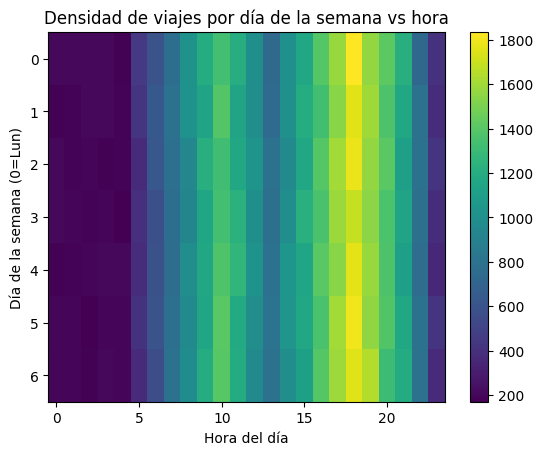

In [4]:
# Mapa de calor: día de la semana vs hora
pivot_counts = df.pivot_table(index="dayofweek", columns="hour", values=df.columns[0], aggfunc="count", fill_value=0)
plt.figure()
plt.imshow(pivot_counts.values, aspect="auto")
plt.title("Densidad de viajes por día de la semana vs hora")
plt.xlabel("Hora del día")
plt.ylabel("Día de la semana (0=Lun)")
plt.colorbar()
plt.show()


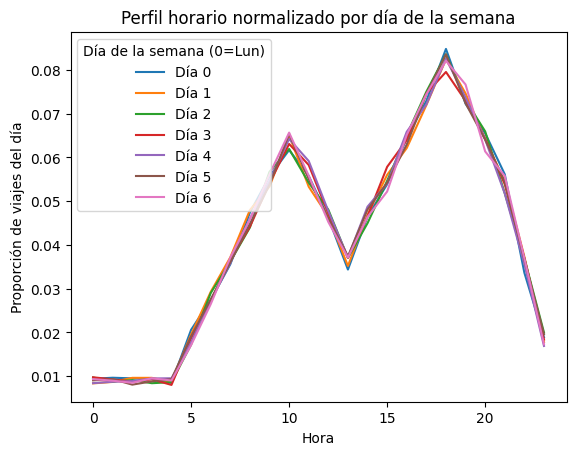

In [5]:
# Perfil horario normalizado por día de la semana
hourly_by_dow = df.groupby(["dayofweek", "hour"]).size().reset_index(name="count")
day_sizes = df.groupby("dayofweek").size()
hourly_by_dow["norm"] = hourly_by_dow.apply(lambda r: r["count"] / day_sizes.loc[r["dayofweek"]], axis=1)

plt.figure()
for d in sorted(hourly_by_dow["dayofweek"].unique()):
    sub = hourly_by_dow[hourly_by_dow["dayofweek"] == d]
    plt.plot(sub["hour"], sub["norm"], label=f"Día {int(d)}")
plt.legend(title="Día de la semana (0=Lun)")
plt.title("Perfil horario normalizado por día de la semana")
plt.xlabel("Hora")
plt.ylabel("Proporción de viajes del día")
plt.show()



## Interpretación y vínculo con las preguntas
- **H1 (pico laboral):** Si el mapa de calor muestra intensidades altas en 7–9 y 17–20 en días 0–4, se apoya la hipótesis de picos laborales.
- **H2 (ocio/nocturno):** Incrementos en las últimas horas del día de los días 4–5 respaldarían mayor demanda nocturna de fin de semana.
- **H3 (estacionalidad):** Diferencias notorias por **mes** en conteos totales o en perfiles horarios apoyarían la presencia de estacionalidad.
